In [506]:
# Install the transformers library from the Hugging Face repository
# !c:/Users/benjamin.guerrieri/AppData/Local/Programs/Python/Python311/python.exe -m pip install --trusted-host pypi.org --trusted-host pypi.python.org --trusted-host files.pythonhosted.org pip install -q git+https://github.com/huggingface/transformers.git 

In [507]:
# Install the 'timm' library using pip
# !c:/Users/benjamin.guerrieri/AppData/Local/Programs/Python/Python311/python.exe -m pip install --trusted-host pypi.org --trusted-host pypi.python.org --trusted-host files.pythonhosted.org pip install -q timm

The model we are loading is the "microsoft/table-transformer-detection" model. This model is designed to perform object detection tasks specifically on tabular data, such as tables in documents or spreadsheets.

We will visualize our image with matplotlib. The function creates a visualization by overlaying rectangles (bounding boxes) on the image to represent the detected objects and adding text annotations with the corresponding label and score.

In [508]:
import matplotlib.pyplot as plt
path = 'output.png'
from transformers import DetrFeatureExtractor
feature_extractor = DetrFeatureExtractor()
# Define colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

def plot_rows_and_cols(pil_img, scores, labels, boxes):
    # Create a figure for visualization
    plt.figure(figsize=(16, 10))

    # Display the PIL image
    plt.imshow(pil_img)

    # Get the current axis
    ax = plt.gca()

    # Repeat the COLORS list multiple times for visualization
    colors = COLORS * 100
    i = 1
    # Iterate through scores, labels, boxes, and colors for visualization
    for score, label, (xmin, ymin, xmax, ymax), c in zip(scores.tolist(), labels.tolist(), boxes.tolist(), colors):
        # Add a rectangle to the image for the detected object's bounding box
        if model.config.id2label[label] == 'table row' or model.config.id2label[label] == 'table column':
            ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                    fill=False, color=c, linewidth=3))

            # Prepare the text for the label and score
            text = f'{model.config.id2label[label]}: {str(i)}'

            # Add the label and score text to the image
            ax.text(xmin, ymin, text, fontsize=15,
                    bbox=dict(facecolor='yellow', alpha=0.5))
        i+=1

    # Turn off the axis
    plt.axis('off')

    # Display the visualization
    plt.show()

def plot_spanning_cells(pil_img, scores, labels, boxes):
    # Create a figure for visualization
    plt.figure(figsize=(16, 10))

    # Display the PIL image
    plt.imshow(pil_img)

    # Get the current axis
    ax = plt.gca()

    # Repeat the COLORS list multiple times for visualization
    colors = COLORS * 100

    # Iterate through scores, labels, boxes, and colors for visualization
    for score, label, (xmin, ymin, xmax, ymax), c in zip(scores.tolist(), labels.tolist(), boxes.tolist(), colors):
        if model.config.id2label[label] == 'table spanning cell':
            # Add a rectangle to the image for the detected object's bounding box
            ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                    fill=False, color=c, linewidth=3))

            # Prepare the text for the label and score
            text = f'{model.config.id2label[label]}: {score:0.2f}'

            # Add the label and score text to the image
            ax.text(xmin, ymin, text, fontsize=15,
                    bbox=dict(facecolor='yellow', alpha=0.5))

    # Turn off the axis
    plt.axis('off')

    # Display the visualization
    plt.show()

c:\Users\benjamin.guerrieri\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\models\detr\feature_extraction_detr.py:38: FutureWarning: The class DetrFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use DetrImageProcessor instead.
  warnings.warn(


  This has detected the presence of a table perfectly. We will now try to detect the rows and columns. As noted in the article, two separate approaches were used for this different objectives.

In [509]:
# Import the necessary libraries
from PIL import Image

# Download the image file from the specified Hugging Face repository and location
# Use either of the provided 'repo_id' lines depending on your use case
file_path = path

# Open the downloaded image using the PIL library and convert it to RGB format
image = Image.open(file_path).convert("RGB")

# Get the original width and height of the image
width, height = image.size

# Resize the image to 90% of its original dimensions
resized_image = image.resize((int(width * 0.9), int(height * 0.9)))

In [510]:
# Use the feature extractor to encode the resized image

encoding = feature_extractor(image, return_tensors="pt")

# Get the keys of the encoding dictionary
keys = encoding.keys()

Let's load the model from the hub, and perform a forward pass.

In [511]:
# Import the TableTransformerForObjectDetection class from the transformers library
from transformers import TableTransformerForObjectDetection

# Load the pre-trained Table Transformer model for table structure recognition
model =  TableTransformerForObjectDetection.from_pretrained("./table-transformer-updated/table-transformer-structure-recognition-v1.1-all")

In [512]:
import torch
with torch.no_grad():
  outputs = model(**encoding)

Let's visualize the results!

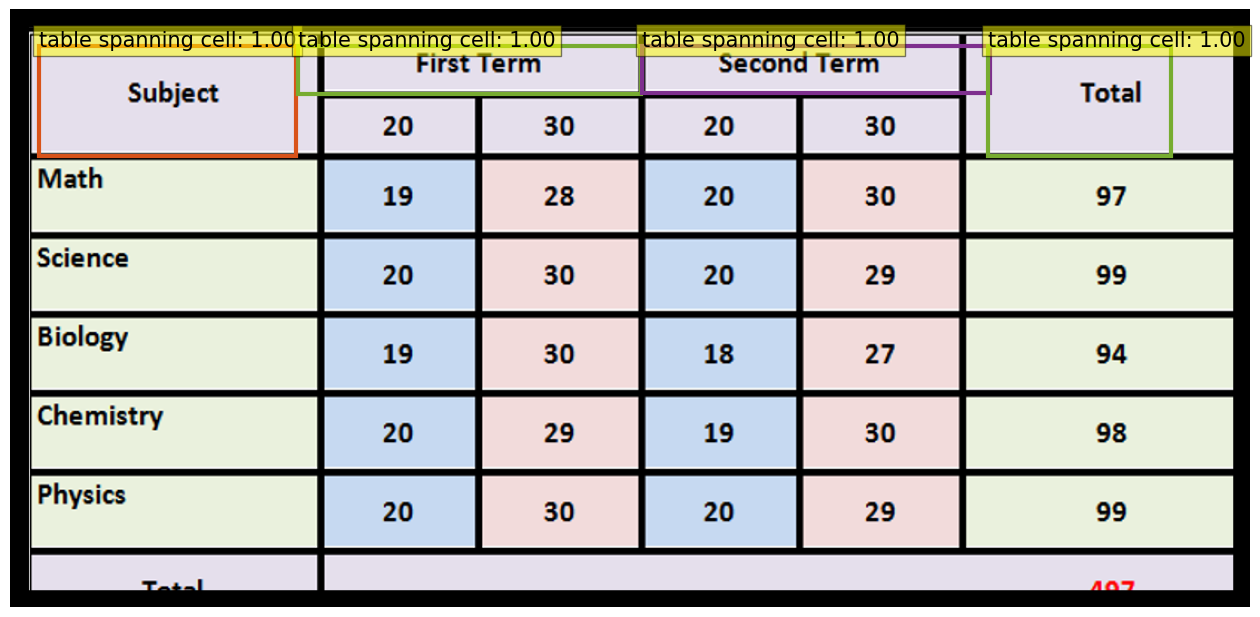

In [513]:
# Create a list of target sizes for post-processing
# 'image.size[::-1]' swaps the width and height to match the target size format (height, width)
target_sizes = [image.size[::-1]]

# Post-process the object detection outputs using the feature extractor
# Use a threshold of 0.6 for confidence
results = feature_extractor.post_process_object_detection(outputs, threshold=0.6, target_sizes=target_sizes)[0]

# Plot the visualization of the results
plot_spanning_cells(image, results['scores'], results['labels'], results['boxes'])
#figure out how many rows and columns each spanning cell takes up


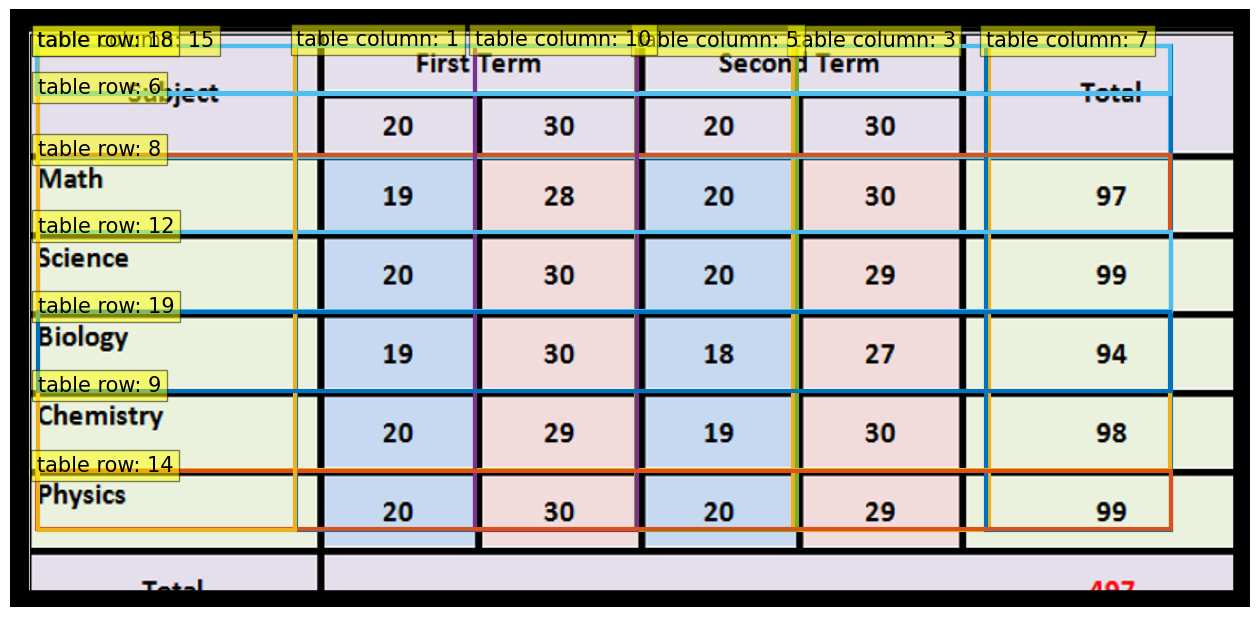

In [514]:
plot_rows_and_cols(image, results['scores'], results['labels'], results['boxes'])

In [515]:
model.config.id2label

{0: 'table',
 1: 'table column',
 2: 'table row',
 3: 'table column header',
 4: 'table projected row header',
 5: 'table spanning cell'}

In [516]:
import pandas as pd
from pytesseract import pytesseract
path_to_cmd = r"C:/Users/benjamin.guerrieri/AppData/Local/Programs/Tesseract-OCR/tesseract.exe"
pytesseract.tesseract_cmd = path_to_cmd


def isolate_cells(image, row_boxes, col_boxes, label_ids, id2label):
    row_boxes = sorted(row_boxes, key=lambda x: (x[1], x[0]))  # Sort by ymin and then xmin
    col_boxes = sorted(col_boxes, key=lambda x: (x[0], x[1]))  # Sort by xmin and then ymin
    
    cell_data = []
    
    for row_index, row_box in enumerate(row_boxes):
        for col_index, col_box in enumerate(col_boxes):
            # Extract coordinates for the current cell
            xmin_row, ymin_row, xmax_row, ymax_row = map(int, row_box)
            xmin_col, ymin_col, xmax_col, ymax_col = map(int, col_box)
            
            # Crop the current cell from the image
            cell_image = image.crop((xmin_col, ymin_row, xmax_col, ymax_row))
            bbox = (xmin_col, ymin_row, xmax_col, ymax_row)
            # Add cell data to the list
            cell_data.append((cell_image, row_index, col_index, bbox))
    
    # Sort the cell data based on row and column indices
    cell_data.sort(key=lambda x: (x[1], x[2]))
    
    return cell_data

# Example usage:
row_label_id = model.config.label2id['table row']
col_label_id = model.config.label2id['table column']

row_boxes = results['boxes'][results['labels'] == row_label_id]
col_boxes = results['boxes'][results['labels'] == col_label_id]

isolated_cells_data = isolate_cells(image, row_boxes, col_boxes, [row_label_id, col_label_id], model.config.id2label)

# # Create a DataFrame from the isolated cell data
# columns = ['Row', 'Column', 'Cell Contents']
# df_cells = pd.DataFrame(columns=columns)

# rows_list = []

# # Save or display the isolated cell images and update the list
# for i, (cell_image, row_index, col_index, bbox) in enumerate(isolated_cells_data):
#     # image_path = f'isolated_cell_{i}.png'
#     # cell_image.save(image_path)
#     result = pytesseract.image_to_string(cell_image)
#     cleaned_result = result.replace('\n', ' ').strip()

#     rows_list.append({'Row': row_index, 'Column': col_index, 'Cell Contents': cleaned_result})

# # Create a DataFrame from the list
# df_cells = pd.DataFrame(rows_list)

# # Sort the DataFrame based on Row and Column columns
# df_cells = df_cells.sort_values(by=['Row', 'Column']).reset_index(drop=True)

# # Display the sorted DataFrame
# df_cells


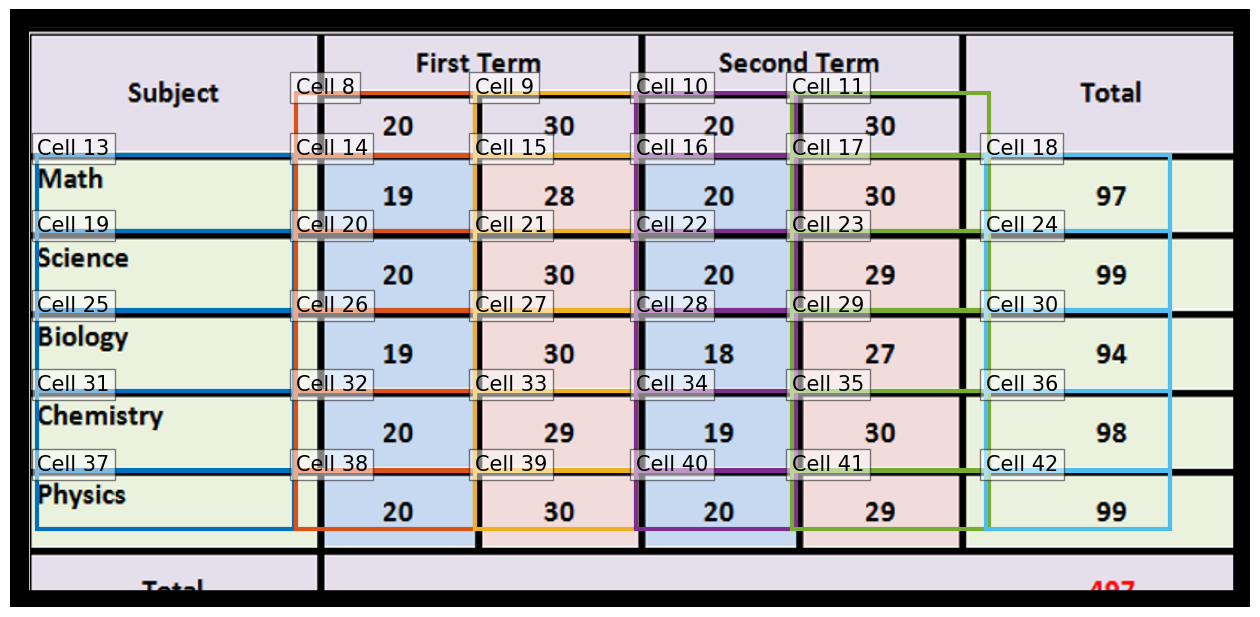

[tensor([ 25.1904,  32.9379, 256.7423, 130.9442]),
 tensor([258.1634,  32.9379, 565.9463,  75.2668]),
 tensor([566.9625,  32.9379, 879.6985,  75.1656]),
 tensor([ 877.7803,   32.9379, 1042.6833,  131.1845]),
 (256, 75, 417, 131),
 (417, 75, 562, 131),
 (562, 75, 706, 131),
 (702, 75, 879, 131),
 (24, 130, 255, 199),
 (256, 130, 417, 199),
 (417, 130, 562, 199),
 (562, 130, 706, 199),
 (702, 130, 879, 199),
 (876, 130, 1042, 199),
 (24, 199, 255, 270),
 (256, 199, 417, 270),
 (417, 199, 562, 270),
 (562, 199, 706, 270),
 (702, 199, 879, 270),
 (876, 199, 1042, 270),
 (24, 271, 255, 342),
 (256, 271, 417, 342),
 (417, 271, 562, 342),
 (562, 271, 706, 342),
 (702, 271, 879, 342),
 (876, 271, 1042, 342),
 (24, 342, 255, 413),
 (256, 342, 417, 413),
 (417, 342, 562, 413),
 (562, 342, 706, 413),
 (702, 342, 879, 413),
 (876, 342, 1042, 413),
 (24, 414, 255, 466),
 (256, 414, 417, 466),
 (417, 414, 562, 466),
 (562, 414, 706, 466),
 (702, 414, 879, 466),
 (876, 414, 1042, 466)]

In [517]:

# def is_bbox_intersecting(bbox1, bbox2):
#     x_min1, y_min1, x_max1, y_max1 = bbox1
#     x_min2, y_min2, x_max2, y_max2 = bbox2

#     return not (x_max1 < x_min2 or x_min1 > x_max2 or y_max1 < y_min2 or y_min1 > y_max2)


def is_bbox_majority_within(bbox1, bbox2, threshold=0.5):
    x_min1, y_min1, x_max1, y_max1 = bbox1
    x_min2, y_min2, x_max2, y_max2 = bbox2

    intersection_x_min = max(x_min1, x_min2)
    intersection_y_min = max(y_min1, y_min2)
    intersection_x_max = min(x_max1, x_max2)
    intersection_y_max = min(y_max1, y_max2)

    intersection_area = max(0, intersection_x_max - intersection_x_min) * max(0, intersection_y_max - intersection_y_min)
    cell_area = (x_max1 - x_min1) * (y_max1 - y_min1)

    return (intersection_area / cell_area) > threshold

def is_cell_outside_all_bounding_boxes(cell_bbox, spanning_boxes):
    for spanning_box in spanning_boxes:
        if is_bbox_majority_within(cell_bbox, spanning_box):
            return False
    return True

def plot_cells(pil_img, cell_data, spanning_cells):
    # Create a figure for visualization
    plt.figure(figsize=(16, 10))

    # Display the PIL image
    plt.imshow(pil_img)

    # Get the current axis
    ax = plt.gca()

    # Repeat the COLORS list multiple times for visualization
    colors = COLORS * 100
    all_cells = []
    # Iterate through scores, labels, boxes, and colors for visualization
    for i, (cell_image, row_index, col_index, bbox) in enumerate(cell_data):
        xmin_col, ymin_row, xmax_col, ymax_row = bbox
        if is_cell_outside_all_bounding_boxes(bbox,spanning_cells):
            ax.add_patch(plt.Rectangle((xmin_col, ymin_row), xmax_col-xmin_col, ymax_row-ymin_row,
                                        fill=False, color=colors[i], linewidth=3))
            text = f'Cell {i + 1}'
            ax.text(xmin_col, ymin_row, text, fontsize=15,
                            bbox=dict(facecolor='white', alpha=0.5))
            all_cells.append(bbox)
        else:
            i-=1
    for spanning_bbox in spanning_cells:
        all_cells.append(spanning_bbox)
    all_cells = sorted(all_cells, key=lambda x: x[0]) #gets in l to r top down order hopefully
    all_cells = sorted(all_cells, key=lambda x: x[1]) #gets in l to r top down order hopefully
    
    # Turn off the axis
    plt.axis('off')

    # Display the visualization
    plt.show()
    return all_cells

span_label_id = model.config.label2id['table spanning cell']
spanning_boxes = results['boxes'][results['labels'] == span_label_id]
#fix small error
spanning_boxes = sorted(spanning_boxes, key=lambda x: (x[0],x[1])) #gets in correct order
for i, _ in enumerate(spanning_boxes):
    for j,_ in enumerate(spanning_boxes):
        if abs(spanning_boxes[i][1] - spanning_boxes[j][1]) <= 2:
            spanning_boxes[i][1] = spanning_boxes[j][1]
        if abs(spanning_boxes[i][0] - spanning_boxes[j][0]) <= 2:
            spanning_boxes[i][0] = spanning_boxes[j][0]

sorted_cells = plot_cells(image,isolated_cells_data,spanning_boxes)
sorted_cells

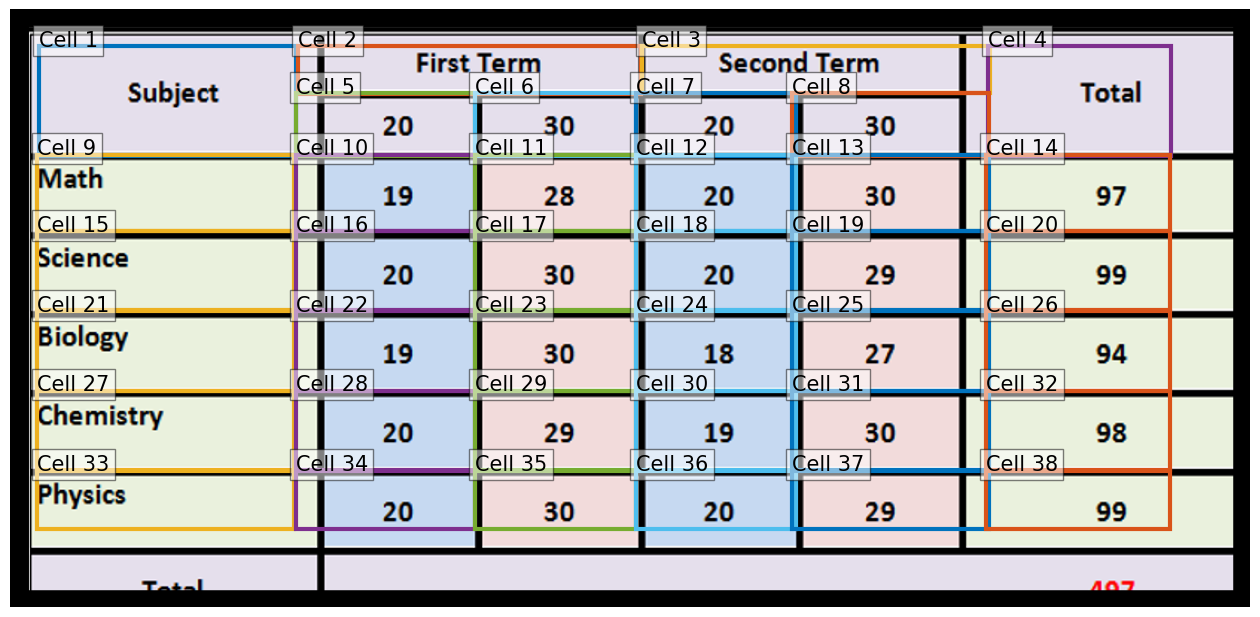

In [518]:
plt.figure(figsize=(16, 10))

# Display the PIL image
plt.imshow(image)
colors = COLORS * 100

# Get the current axis
ax = plt.gca()

for i, bbox in enumerate(sorted_cells):
    xmin_col, ymin_row, xmax_col, ymax_row = bbox
    ax.add_patch(plt.Rectangle((xmin_col, ymin_row), xmax_col-xmin_col, ymax_row-ymin_row,
                                fill=False, color=colors[i], linewidth=3))
    text = f'Cell {i + 1}'
    ax.text(xmin_col, ymin_row, text, fontsize=15,
                    bbox=dict(facecolor='white', alpha=0.5))


# Turn off the axis
plt.axis('off')

# Display the visualization
plt.show()

In [519]:
max_row, max_col = -1, -1
for i in range(len(df_cells)):
    max_row = max(max_row, int(df_cells.loc[i, 'Row']))
    max_col = max(max_col, int(df_cells.loc[i, 'Column']))
max_row+=1
max_col+=1
final_array = [[0] * max_col for _ in range(max_row)]
 
for i in range(len(df_cells)):
    final_array[int(df_cells.loc[i, 'Row'])][int(df_cells.loc[i, 'Column'])] = df_cells.loc[i, 'Cell Contents']
 
new_df = pd.DataFrame(final_array)
new_df

,0,1,2,3,4,5
0,,Table 1:,Salt Concentratic,in and Light Trans,smittance,
1,,,,Transmittance (%1,,
2,-ONCENL SON (%) |,Trial #1,,| Trial #3,,
3,,77.23,74.50,,75.27,
4,,85.23,| 92.82,,60.71,
5,,88.39,| 100.05,73.66,,
6,,80.71,100.05,68.29,,
7,,82.66,| 117.18,| 71.01,56.91,46.95
8,,72.55,115.40,65.72,,55.38


In [520]:
finalized_data = new_df

with pd.ExcelWriter(r'C:/Users/benjamin.guerrieri/Documents/TableOCR/PipeLine/test.xlsx') as writer:
    finalized_data.to_excel(writer,sheet_name = 'table',index = False)